Comparison of the two extraction approaches

c:\Users\gabyf\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


--- Preparing Data ---
Data preparation complete.

--- Section A: High-Level Performance Overview ---
                              LLM  RuleBased
Endpoints_Score             0.932      0.694
Statistical_Score           0.915      0.840
Adverse_Events_Score        0.741      0.704
Clinical_Lab_Score          0.884      0.809
Total_Score                 0.877      0.767
Endpoints_FreeText_F1       0.974      0.718
Statistical_FreeText_F1     0.983      0.967
Adverse_Events_FreeText_F1  0.700      0.714
Clinical_Lab_FreeText_F1    0.956      0.818
Endpoints_Tables_F1         0.930      0.753
Statistical_Tables_F1       0.986      0.766
Adverse_Events_Tables_F1    0.980      0.923
Clinical_Lab_Tables_F1      0.797      0.804
Endpoints_Levenshtein       0.054      0.366
Statistical_Levenshtein     0.012      0.103
Adverse_Events_Levenshtein  0.208      0.271
Clinical_Lab_Levenshtein    0.081      0.193


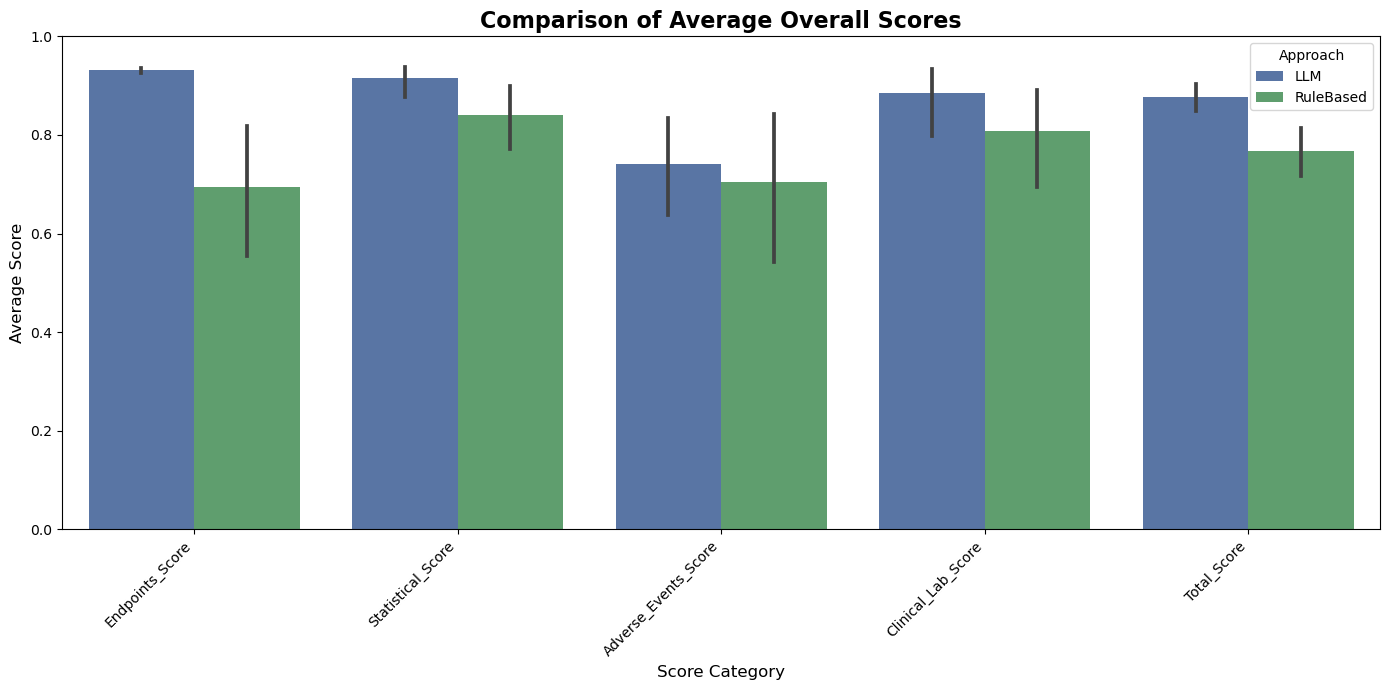

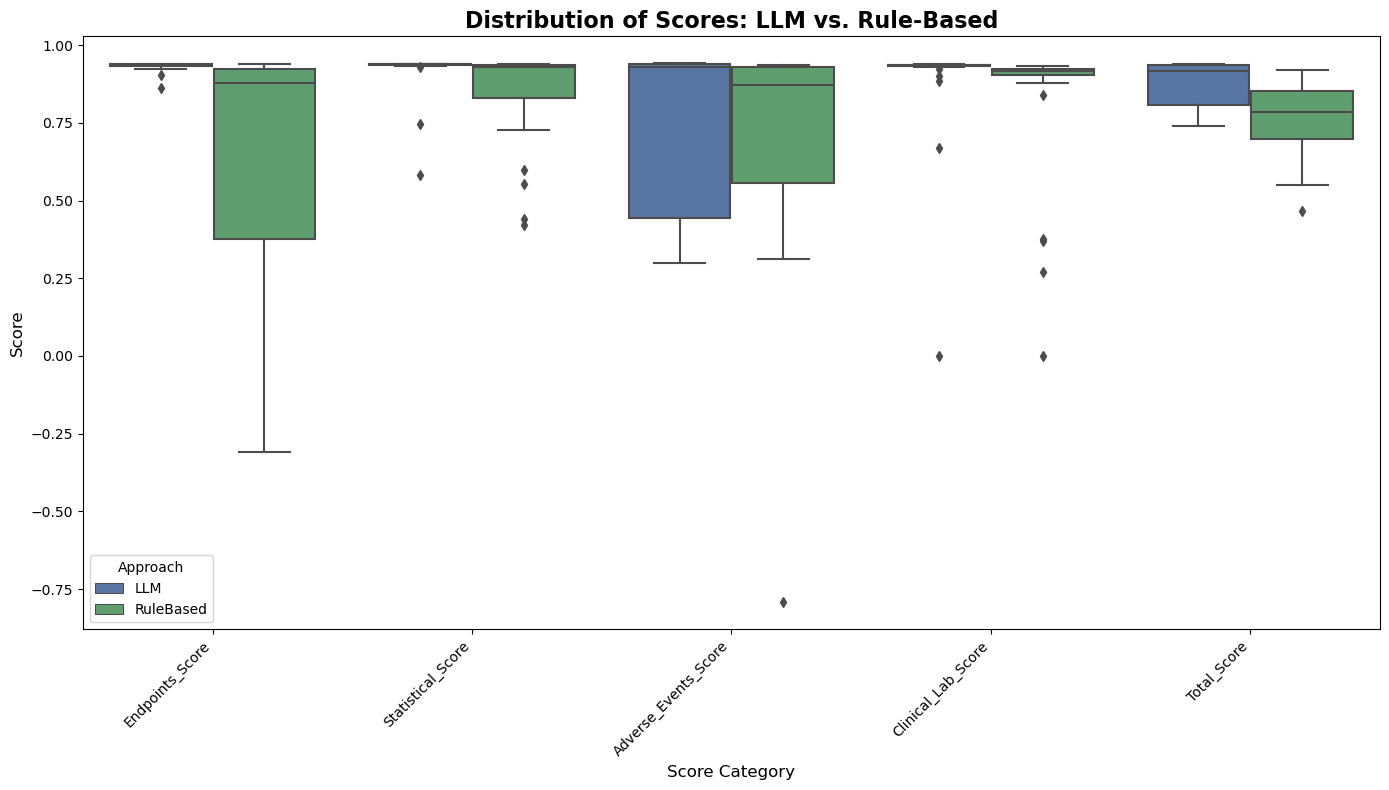


--- Section B: Head-to-Head Protocol Analysis ---


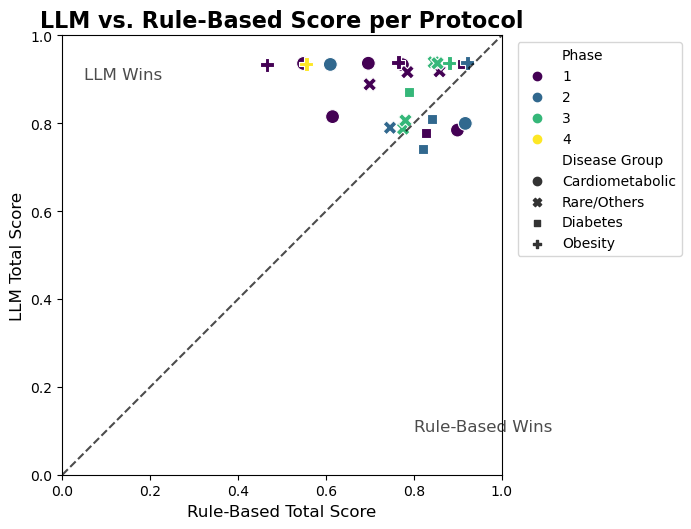

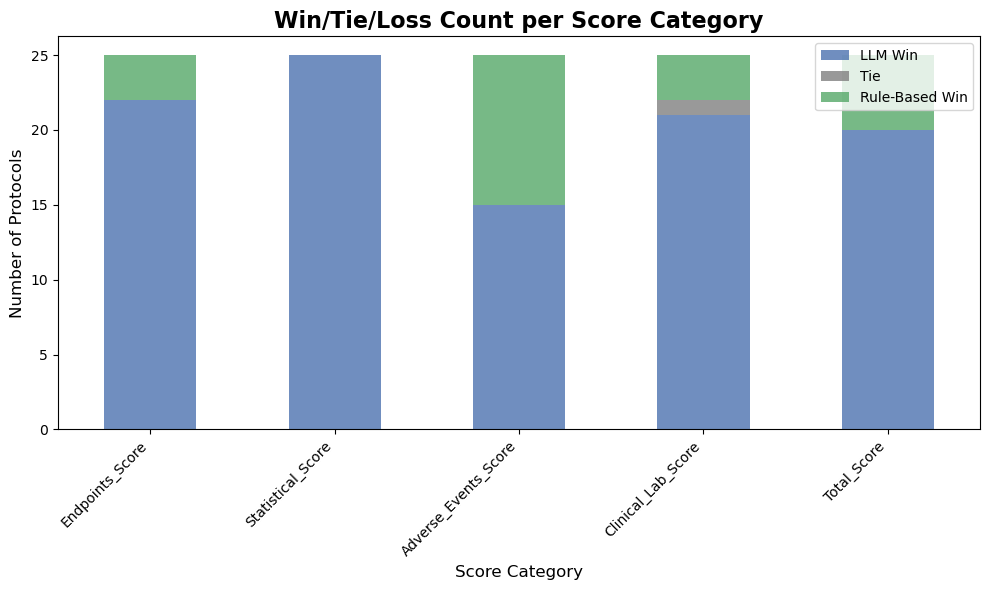


--- Section C: Deep-Dive into Performance Drivers ---


<Figure size 1400x800 with 0 Axes>

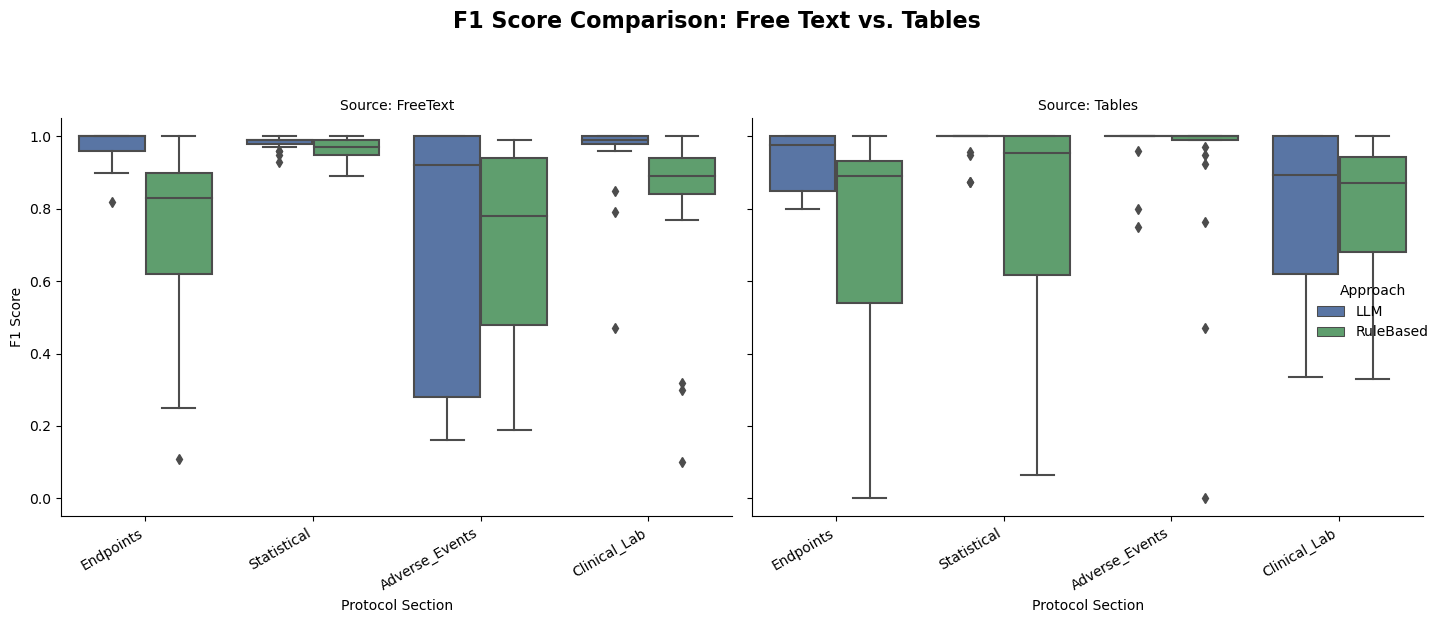

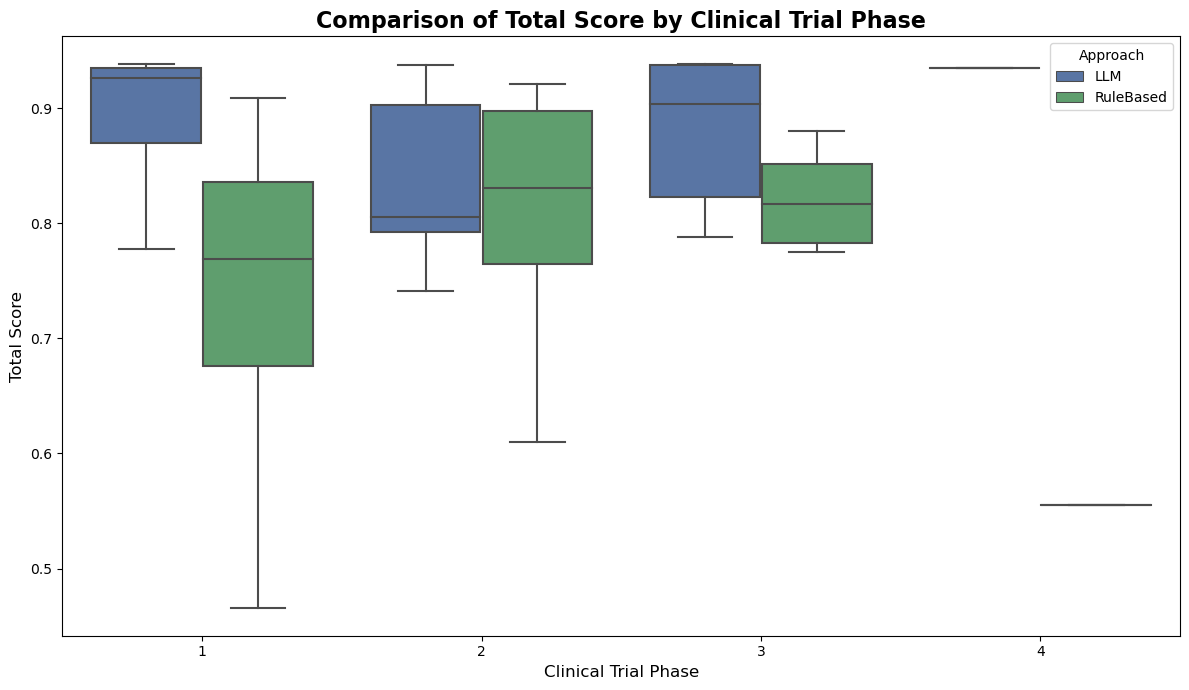

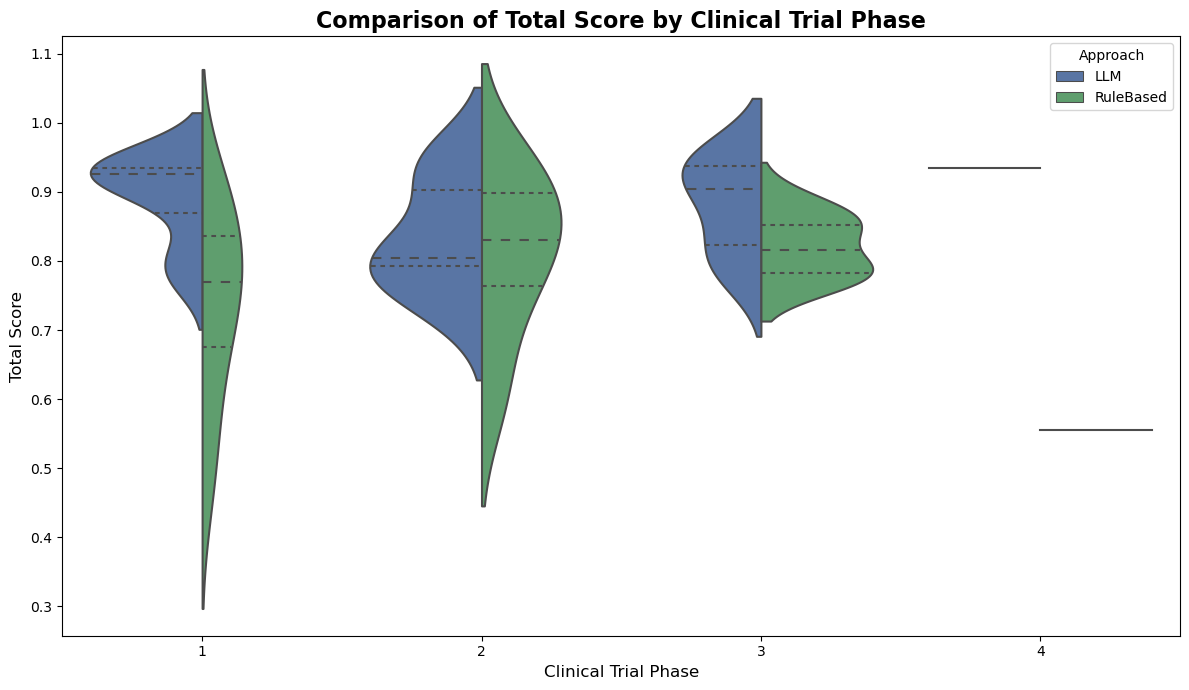

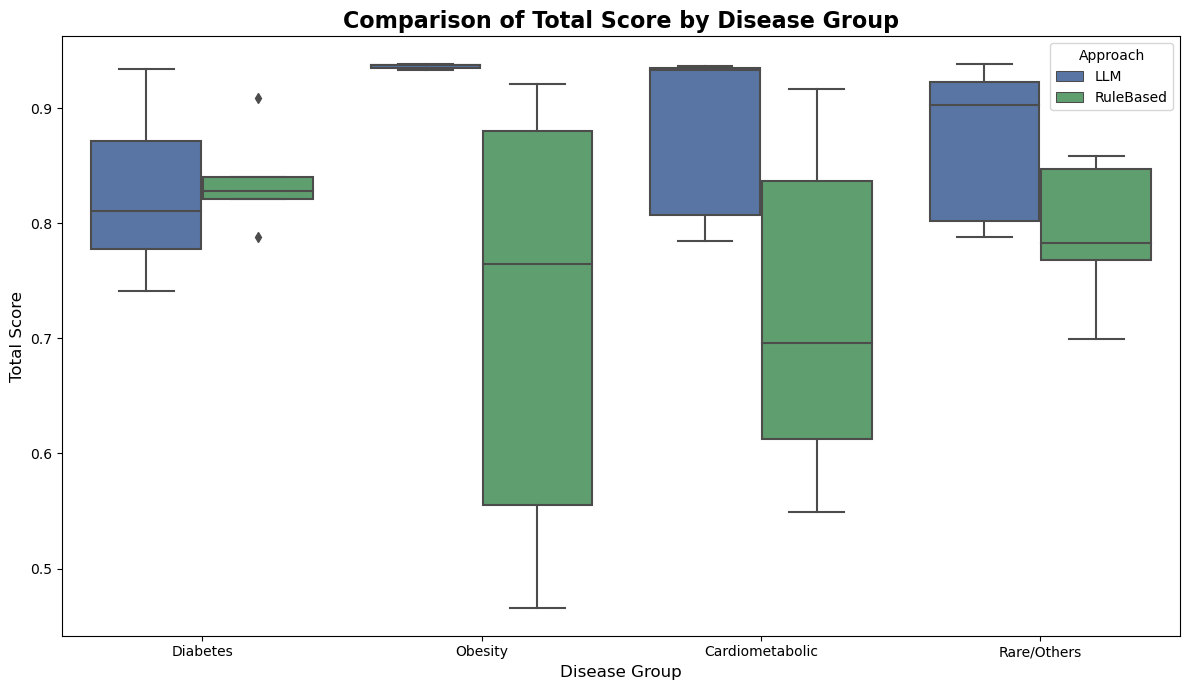

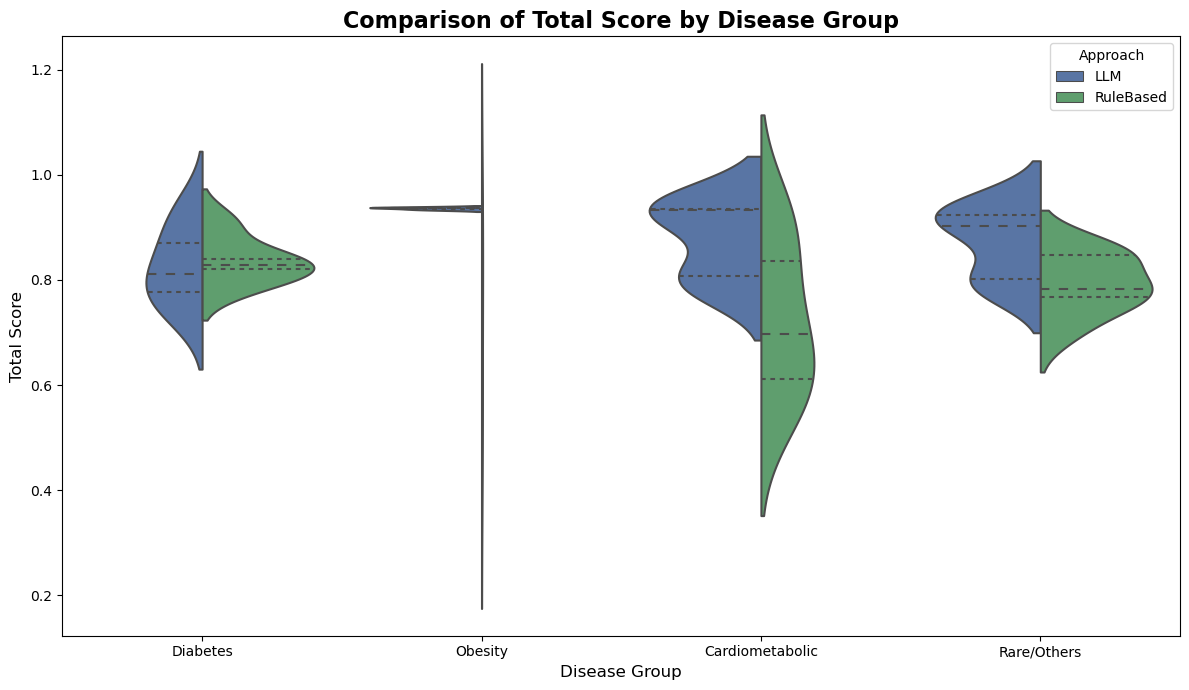

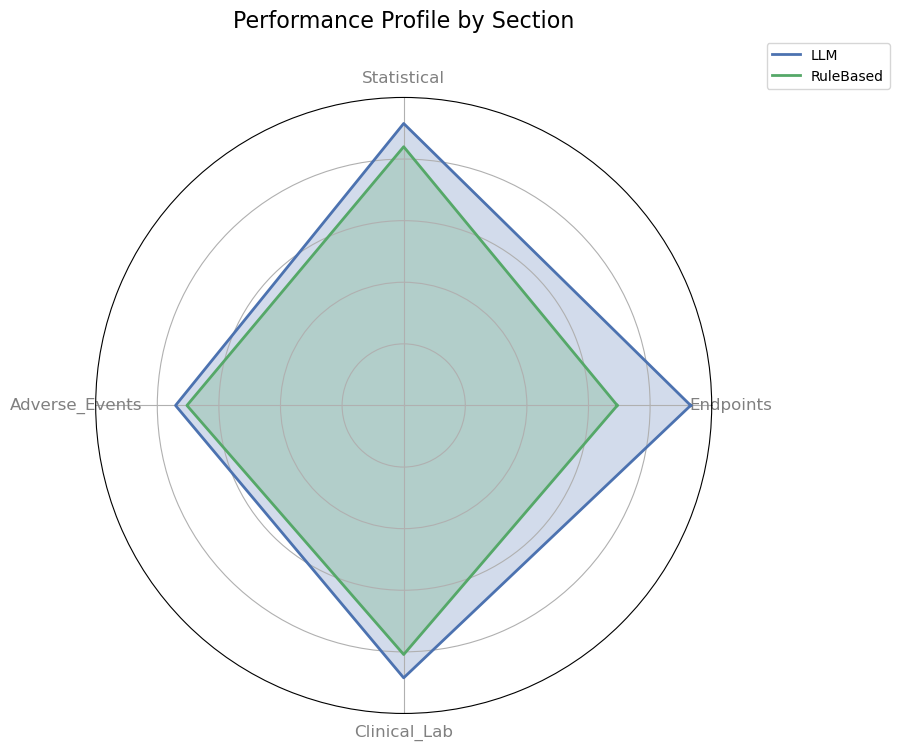


--- Section D: Comprehensive Statistical Summary ---


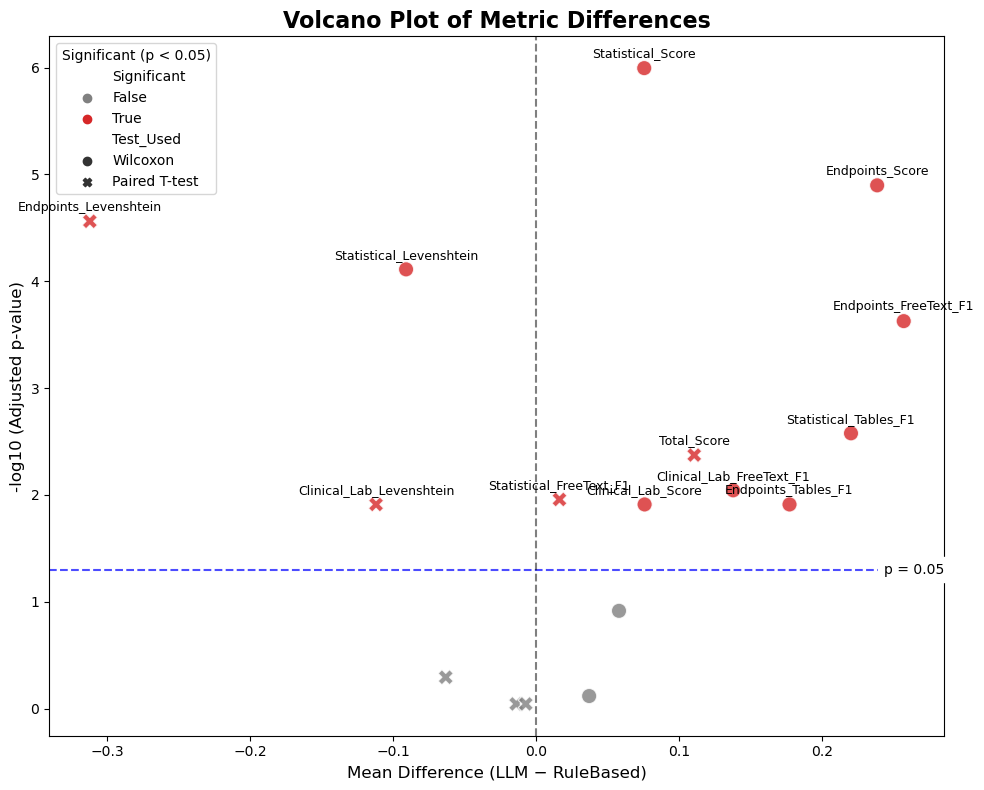


--- Final Statistical Test Results ---
                    Metric     Test_Used  Mean_Difference  p_value_corrected  Significant
         Statistical_Score      Wilcoxon       7.5463e-02         1.0133e-06         True
           Endpoints_Score      Wilcoxon       2.3824e-01         1.2666e-05         True
     Endpoints_Levenshtein Paired T-test      -3.1195e-01         2.7463e-05         True
   Statistical_Levenshtein      Wilcoxon      -9.0965e-02         7.7415e-05         True
     Endpoints_FreeText_F1      Wilcoxon       2.5680e-01         2.3620e-04         True
     Statistical_Tables_F1      Wilcoxon       2.1996e-01         2.6494e-03         True
               Total_Score Paired T-test       1.1040e-01         4.2329e-03         True
  Clinical_Lab_FreeText_F1      Wilcoxon       1.3760e-01         9.0505e-03         True
   Statistical_FreeText_F1 Paired T-test       1.6240e-02         1.1021e-02         True
       Endpoints_Tables_F1      Wilcoxon       1.7699e-01   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

LLM_FILE_PATH = "llm_extraction_evaluation.xlsx"
RULE_BASED_FILE_PATH = "extraction_evaluation.xlsx"
OUTPUT_FILE = "extraction_comparison_results.xlsx"
SHEETS = [f'Sheet{i}' for i in range(1, 26)]
METADATA_SHEET_NAME = "Gold standard"
# Set a consistent color palette for the approaches
APPROACH_PALETTE = {"LLM": "#4c72b0", "RuleBased": "#55a868"}


def load_and_process_data(file_path):
    metrics_per_protocol = {
        "Protocol": SHEETS,
        "Endpoints_Score": [], "Statistical_Score": [], "Adverse_Events_Score": [], "Clinical_Lab_Score": [], "Total_Score": [],
        "Endpoints_FreeText_F1": [], "Statistical_FreeText_F1": [], "Adverse_Events_FreeText_F1": [], "Clinical_Lab_FreeText_F1": [],
        "Endpoints_Tables_F1": [], "Statistical_Tables_F1": [], "Adverse_Events_Tables_F1": [], "Clinical_Lab_Tables_F1": [],
        "Endpoints_Levenshtein": [], "Statistical_Levenshtein": [], "Adverse_Events_Levenshtein": [], "Clinical_Lab_Levenshtein": [],
    }
    all_metrics = list(metrics_per_protocol.keys())[1:]
    for sheet in SHEETS:
        try:
            df = pd.read_excel(file_path, sheet_name=sheet, header=None)
            metrics_per_protocol["Endpoints_Score"].append(df.iloc[15, 1])
            metrics_per_protocol["Statistical_Score"].append(df.iloc[16, 1])
            metrics_per_protocol["Adverse_Events_Score"].append(df.iloc[17, 1])
            metrics_per_protocol["Clinical_Lab_Score"].append(df.iloc[18, 1])
            metrics_per_protocol["Total_Score"].append(df.iloc[19, 1])
            metrics_per_protocol["Endpoints_FreeText_F1"].append(df.iloc[3, 7])
            metrics_per_protocol["Statistical_FreeText_F1"].append(df.iloc[3, 35])
            metrics_per_protocol["Adverse_Events_FreeText_F1"].append(df.iloc[3, 64])
            metrics_per_protocol["Clinical_Lab_FreeText_F1"].append(df.iloc[3, 92])
            metrics_per_protocol["Endpoints_Tables_F1"].append(df.iloc[3:14, 19].astype(float).mean())
            metrics_per_protocol["Statistical_Tables_F1"].append(df.iloc[3:14, 47].astype(float).mean())
            metrics_per_protocol["Adverse_Events_Tables_F1"].append(df.iloc[3:14, 76].astype(float).mean())
            metrics_per_protocol["Clinical_Lab_Tables_F1"].append(df.iloc[3:14, 104].astype(float).mean())
            metrics_per_protocol["Endpoints_Levenshtein"].append(np.nanmean([df.iloc[3, 9], df.iloc[3:14, 21].astype(float).mean()]))
            metrics_per_protocol["Statistical_Levenshtein"].append(np.nanmean([df.iloc[3, 37], df.iloc[3:14, 49].astype(float).mean()]))
            metrics_per_protocol["Adverse_Events_Levenshtein"].append(np.nanmean([df.iloc[3, 66], df.iloc[3:14, 78].astype(float).mean()]))
            metrics_per_protocol["Clinical_Lab_Levenshtein"].append(np.nanmean([df.iloc[3, 94], df.iloc[3:14, 106].astype(float).mean()]))
        except Exception as e:
            print(f"Error processing sheet '{sheet}' in file '{file_path}': {e}. Appending NaNs.")
            for key in all_metrics:
                metrics_per_protocol[key].append(np.nan)
    return pd.DataFrame(metrics_per_protocol), all_metrics

def disease_group(disease):
    """Categorizes diseases into broader groups for analysis."""
    d = str(disease).lower()
    if d in ["diabetes", "obesity, diabetes"]: return "Diabetes"
    elif d == "obesity": return "Obesity"
    elif d in ["cardiovascular disease", "non-alcoholic steatohepatitis (nash)", "liver disease", "hereditary haemochromatosis (hh)"]: return "Cardiometabolic"
    else: return "Rare/Others"

llm_df, metric_names = load_and_process_data(LLM_FILE_PATH)
rule_based_df, _ = load_and_process_data(RULE_BASED_FILE_PATH)
metadata_df = pd.read_excel(LLM_FILE_PATH, sheet_name=METADATA_SHEET_NAME, engine='openpyxl')

comparison_df = pd.merge(llm_df, rule_based_df, on='Protocol', suffixes=('_LLM', '_RuleBased'))
comparison_df = pd.merge(comparison_df, metadata_df, left_on='Protocol', right_on='Sheet', how='left')
comparison_df['Disease Group'] = comparison_df['Disease'].apply(disease_group)
for metric in metric_names:
    comparison_df[f'Diff_{metric}'] = comparison_df[f'{metric}_LLM'] - comparison_df[f'{metric}_RuleBased']

# Summary Table
summary_data = {}
for metric in metric_names:
    summary_data[metric] = {
        'LLM': comparison_df[f'{metric}_LLM'].mean(),
        'RuleBased': comparison_df[f'{metric}_RuleBased'].mean()
    }
summary_df = pd.DataFrame.from_dict(summary_data, orient='index') # Create from dict and transpose
print(summary_df.round(3))

# Reshape data for plotting
score_metrics_all = [f"{m}_{s}" for m in metric_names if 'Score' in m for s in ['LLM', 'RuleBased']]
plot_data_scores = pd.melt(comparison_df, id_vars=['Protocol'], value_vars=score_metrics_all, var_name='Metric_Raw', value_name='Score')
plot_data_scores[['Metric', 'Approach']] = plot_data_scores['Metric_Raw'].str.rsplit('_', n=1, expand=True)

# Bar Plot of Average Scores
plt.figure(figsize=(14, 7))
sns.barplot(x='Metric', y='Score', hue='Approach', data=plot_data_scores, palette=APPROACH_PALETTE)
plt.title('Comparison of Average Overall Scores', fontsize=16, weight='bold')
plt.ylabel('Average Score', fontsize=12)
plt.xlabel('Score Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='Approach')
plt.tight_layout()
plt.show()

# Box Plot of Score Distributions
plt.figure(figsize=(14, 8))
sns.boxplot(x='Metric', y='Score', hue='Approach', data=plot_data_scores, palette=APPROACH_PALETTE)
plt.title('Distribution of Scores: LLM vs. Rule-Based', fontsize=16, weight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Score Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Approach')
plt.tight_layout()
plt.show()

# Head-to-Head Protocol Analysis
# a) Scatter Plot: Rule-Based vs. LLM (Per Protocol)
plt.figure(figsize=(7, 7))
sns.scatterplot(x="Total_Score_RuleBased", y="Total_Score_LLM", hue="Phase", style="Disease Group", data=comparison_df, palette="viridis", s=100)
plt.plot([0, 1], [0, 1], "k--", alpha=0.7)
plt.xlabel("Rule-Based Total Score", fontsize=12)
plt.ylabel("LLM Total Score", fontsize=12)
plt.title("LLM vs. Rule-Based Score per Protocol", fontsize=16, weight='bold')
plt.text(0.05, 0.9, 'LLM Wins', transform=plt.gca().transAxes, fontsize=12, alpha=0.7)
plt.text(0.8, 0.1, 'Rule-Based Wins', transform=plt.gca().transAxes, fontsize=12, alpha=0.7)
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# b) Win/Tie/Loss Counts per Score Metric
score_metrics_base = [m for m in metric_names if 'Score' in m]
wins_data = []
for m in score_metrics_base:
    counts = np.sign(comparison_df[f"Diff_{m}"]).map({1.0:"LLM Win", 0.0:"Tie", -1.0:"Rule-Based Win"}).value_counts()
    wins_data.append(counts)
wins_df = pd.DataFrame(wins_data, index=score_metrics_base).fillna(0)
wins_df = wins_df[['LLM Win', 'Tie', 'Rule-Based Win']] # Ensure order

wins_df.plot(kind="bar", stacked=True, figsize=(10, 6), color=[APPROACH_PALETTE['LLM'], 'grey', APPROACH_PALETTE['RuleBased']], alpha=0.8)
plt.ylabel("Number of Protocols", fontsize=12)
plt.xlabel("Score Category", fontsize=12)
plt.title("Win/Tie/Loss Count per Score Category", fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Specific Metrics & Subgroups ---

# a) F1 Score Breakdown (Free Text vs. Tables)
f1_metrics = [m for m in metric_names if 'F1' in m]
f1_plot_data = pd.melt(comparison_df, id_vars=['Protocol'], value_vars=[f"{m}_{s}" for m in f1_metrics for s in ['LLM', 'RuleBased']], var_name='Metric_Raw', value_name='F1 Score')
f1_plot_data[['Metric', 'Approach']] = f1_plot_data['Metric_Raw'].str.rsplit('_', n=1, expand=True)

split_metric = f1_plot_data['Metric'].str.rsplit('_', n=2, expand=True)
f1_plot_data['Section'] = split_metric[0]
f1_plot_data['Source'] = split_metric[1] 

plt.figure(figsize=(14, 8))
g = sns.catplot(
    data=f1_plot_data, 
    x='Section', 
    y='F1 Score', 
    hue='Approach', 
    col='Source',  # This creates separate plots for "FreeText" and "Tables"
    kind='box', 
    palette=APPROACH_PALETTE,
    height=6,
    aspect=1.1,
    order=['Endpoints', 'Statistical', 'Adverse_Events', 'Clinical_Lab'] 
)
g.fig.suptitle('F1 Score Comparison: Free Text vs. Tables', y=1.03, fontsize=16, weight='bold')
g.set_axis_labels("Protocol Section", "F1 Score")
g.set_titles("Source: {col_name}")
g.set_xticklabels(rotation=30, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.97]) 
plt.show()



# Performance by Clinical Trial Phase
total_score_long = pd.melt(comparison_df, id_vars=['Protocol', 'Phase'], value_vars=['Total_Score_LLM', 'Total_Score_RuleBased'], var_name='Metric', value_name='Score')
total_score_long['Approach'] = total_score_long['Metric'].apply(lambda x: 'LLM' if 'LLM' in x else 'RuleBased')

plt.figure(figsize=(12, 7))
sns.boxplot(data=total_score_long, x="Phase", y="Score", hue="Approach", palette=APPROACH_PALETTE, order=sorted(comparison_df['Phase'].unique()))
plt.title("Comparison of Total Score by Clinical Trial Phase", fontsize=16, weight='bold')
plt.xlabel("Clinical Trial Phase", fontsize=12)
plt.ylabel("Total Score", fontsize=12)
plt.legend(title='Approach')
plt.tight_layout()
plt.show()


total_score_long = pd.melt(comparison_df, id_vars=['Protocol', 'Phase'], value_vars=['Total_Score_LLM', 'Total_Score_RuleBased'], var_name='Metric', value_name='Score')
total_score_long['Approach'] = total_score_long['Metric'].apply(lambda x: 'LLM' if 'LLM' in x else 'RuleBased')

plt.figure(figsize=(12, 7))
sns.violinplot(data=total_score_long, x="Phase", y="Score", hue="Approach", palette=APPROACH_PALETTE, order=sorted(comparison_df['Phase'].unique()), split=True, inner="quartile")
plt.title("Comparison of Total Score by Clinical Trial Phase", fontsize=16, weight='bold')
plt.xlabel("Clinical Trial Phase", fontsize=12)
plt.ylabel("Total Score", fontsize=12)
plt.legend(title='Approach')
plt.tight_layout()
plt.show()

# Performance by Disease Group
disease_group_long = pd.melt(comparison_df, id_vars=['Protocol', 'Disease Group'], value_vars=['Total_Score_LLM', 'Total_Score_RuleBased'], var_name='Metric', value_name='Score')
disease_group_long['Approach'] = disease_group_long['Metric'].apply(lambda x: 'LLM' if 'LLM' in x else 'RuleBased')

plt.figure(figsize=(12, 7))
group_order = ["Diabetes", "Obesity", "Cardiometabolic", "Rare/Others"]
sns.boxplot(data=disease_group_long, x="Disease Group", y="Score", hue="Approach", palette=APPROACH_PALETTE, order=group_order)
plt.title("Comparison of Total Score by Disease Group", fontsize=16, weight='bold')
plt.xlabel("Disease Group", fontsize=12)
plt.ylabel("Total Score", fontsize=12)
plt.legend(title='Approach')
plt.tight_layout()
plt.show()

# Performance by Disease Group
disease_group_long = pd.melt(comparison_df, id_vars=['Protocol', 'Disease Group'], value_vars=['Total_Score_LLM', 'Total_Score_RuleBased'], var_name='Metric', value_name='Score')
disease_group_long['Approach'] = disease_group_long['Metric'].apply(lambda x: 'LLM' if 'LLM' in x else 'RuleBased')

plt.figure(figsize=(12, 7))
group_order = ["Diabetes", "Obesity", "Cardiometabolic", "Rare/Others"]
sns.violinplot(data=disease_group_long, x="Disease Group", y="Score", hue="Approach", palette=APPROACH_PALETTE, order=group_order, split=True, inner="quartile")
plt.title("Comparison of Total Score by Disease Group", fontsize=16, weight='bold')
plt.xlabel("Disease Group", fontsize=12)
plt.ylabel("Total Score", fontsize=12)
plt.legend(title='Approach')
plt.tight_layout()
plt.show()
# Radar Chart
section_scores = ['Endpoints_Score', 'Statistical_Score', 'Adverse_Events_Score', 'Clinical_Lab_Score']
labels = [s.replace('_Score', '') for s in section_scores]
llm_values = summary_df.loc[section_scores, 'LLM'].values.flatten().tolist()
rule_values = summary_df.loc[section_scores, 'RuleBased'].values.flatten().tolist()

# Number of variables
num_vars = len(labels)
# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

llm_values += llm_values[:1]
rule_values += rule_values[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
# Plot the LLM data
ax.plot(angles, llm_values, color=APPROACH_PALETTE['LLM'], linewidth=2, linestyle='solid', label='LLM')
ax.fill(angles, llm_values, color=APPROACH_PALETTE['LLM'], alpha=0.25)
# Plot the Rule-Based data
ax.plot(angles, rule_values, color=APPROACH_PALETTE['RuleBased'], linewidth=2, linestyle='solid', label='RuleBased')
ax.fill(angles, rule_values, color=APPROACH_PALETTE['RuleBased'], alpha=0.25)

# Add the labels
ax.set_yticklabels([]) # Hide radial labels
plt.xticks(angles[:-1], labels, color='grey', size=12)
# Set the radial grid lines
ax.set_rlabel_position(0)
ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_ylim(0, 1)

plt.title('Performance Profile by Section', size=16, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


# Statistical Summary 
# a) Statistical Testing
test_results = []
alpha = 0.05
for metric in metric_names:
    series_llm, series_rb = comparison_df[f'{metric}_LLM'].dropna(), comparison_df[f'{metric}_RuleBased']
    series_rb = series_rb.loc[series_llm.index]
    if len(series_llm) < 8: continue
    differences = series_llm - series_rb
    shapiro_stat, shapiro_p = stats.shapiro(differences)
    test_name = "Paired T-test" if shapiro_p > alpha else "Wilcoxon"
    if test_name == "Paired T-test":
        stat, p_value = stats.ttest_rel(series_llm, series_rb)
    else:
        stat, p_value = stats.wilcoxon(differences)
    test_results.append({"Metric": metric, "Test_Used": test_name, "p_value_raw": p_value})
results_df = pd.DataFrame(test_results)
if not results_df.empty:
    reject, p_vals_corrected, _, _ = multipletests(results_df['p_value_raw'].fillna(1.0), alpha=alpha, method='fdr_bh')
    results_df['p_value_corrected'] = p_vals_corrected
    results_df['Significant'] = reject

# b) Volcano Plot 
results_df["Mean_Difference"] = results_df["Metric"].apply(lambda m: comparison_df[f"Diff_{m}"].mean())
results_df["neglog10_p"] = -np.log10(results_df["p_value_corrected"])
plt.figure(figsize=(10, 8))
sns.scatterplot(x="Mean_Difference", y="neglog10_p", hue="Significant", data=results_df, palette={True: "#d62728", False: "grey"}, s=120, alpha=0.8, style=results_df['Test_Used'])
plt.axhline(-np.log10(alpha), color="blue", linestyle="--", alpha=0.7)
plt.text(plt.xlim()[1], -np.log10(alpha), 'p = 0.05', va='center', ha='right', backgroundcolor='w', fontsize=10)
plt.axvline(0, color="black", linestyle="--", alpha=0.5)
for i, row in results_df.iterrows():
    if row['Significant']:
        plt.text(row["Mean_Difference"], row["neglog10_p"] + 0.1, row["Metric"], fontsize=9, ha='center')
plt.xlabel("Mean Difference (LLM − RuleBased)", fontsize=12)
plt.ylabel("-log10 (Adjusted p-value)", fontsize=12)
plt.title("Volcano Plot of Metric Differences", fontsize=16, weight='bold')
plt.legend(title='Significant (p < 0.05)', loc='upper left')
plt.tight_layout()
plt.show()

# c) Final Statistical Table
print("\n--- Final Statistical Test Results ---")
pd.set_option('display.float_format', '{:.4e}'.format)
print(results_df[['Metric', 'Test_Used', 'Mean_Difference', 'p_value_corrected', 'Significant']].sort_values('p_value_corrected').to_string(index=False))
pd.reset_option('display.float_format')

#  Export Results 
try:
    comparison_df.to_excel(OUTPUT_FILE, index=False)
    print(f"\nSuccessfully exported the detailed comparison data to '{OUTPUT_FILE}'")
except Exception as e:
    print(f"\nCould not export data to Excel. Error: {e}")

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

LLM_FILE_PATH = "llm_extraction_evaluation.xlsx"
RULE_BASED_FILE_PATH = "extraction_evaluation.xlsx"
OUTPUT_FILE = "extraction_comparison_results.xlsx"

SHEETS = [f'Sheet{i}' for i in range(1, 26)]
METADATA_SHEET_NAME = "Gold standard"

def load_and_process_data(file_path):
  
    metrics_per_protocol = {
        "Protocol": SHEETS,
        "Endpoints_Score": [], "Statistical_Score": [], "Adverse_Events_Score": [], "Clinical_Lab_Score": [], "Total_Score": [],
        "Endpoints_FreeText_F1": [], "Statistical_FreeText_F1": [], "Adverse_Events_FreeText_F1": [], "Clinical_Lab_FreeText_F1": [],
        "Endpoints_Tables_F1": [], "Statistical_Tables_F1": [], "Adverse_Events_Tables_F1": [], "Clinical_Lab_Tables_F1": [],
        "Endpoints_Levenshtein": [], "Statistical_Levenshtein": [], "Adverse_Events_Levenshtein": [], "Clinical_Lab_Levenshtein": [],
    }
    
    all_metrics = list(metrics_per_protocol.keys())
    all_metrics.remove("Protocol")

    for sheet in SHEETS:
        try:
            df = pd.read_excel(file_path, sheet_name=sheet, header=None)
            
            # Overall Scores
            metrics_per_protocol["Endpoints_Score"].append(df.iloc[15, 1])
            metrics_per_protocol["Statistical_Score"].append(df.iloc[16, 1])
            metrics_per_protocol["Adverse_Events_Score"].append(df.iloc[17, 1])
            metrics_per_protocol["Clinical_Lab_Score"].append(df.iloc[18, 1])
            metrics_per_protocol["Total_Score"].append(df.iloc[19, 1])

            # Free Text F1 Scores
            metrics_per_protocol["Endpoints_FreeText_F1"].append(df.iloc[3, 7])
            metrics_per_protocol["Statistical_FreeText_F1"].append(df.iloc[3, 35])
            metrics_per_protocol["Adverse_Events_FreeText_F1"].append(df.iloc[3, 64])
            metrics_per_protocol["Clinical_Lab_FreeText_F1"].append(df.iloc[3, 92])

            # Tables F1 Scores (Averaged over all tables in the section)
            metrics_per_protocol["Endpoints_Tables_F1"].append(df.iloc[3:14, 19].astype(float).mean())
            metrics_per_protocol["Statistical_Tables_F1"].append(df.iloc[3:14, 47].astype(float).mean())
            metrics_per_protocol["Adverse_Events_Tables_F1"].append(df.iloc[3:14, 76].astype(float).mean())
            metrics_per_protocol["Clinical_Lab_Tables_F1"].append(df.iloc[3:14, 104].astype(float).mean())
            
            # Levenshtein Distance 
            ep_lev = np.nanmean([df.iloc[3, 9], df.iloc[3:14, 21].astype(float).mean()])
            stat_lev = np.nanmean([df.iloc[3, 37], df.iloc[3:14, 49].astype(float).mean()])
            ae_lev = np.nanmean([df.iloc[3, 66], df.iloc[3:14, 78].astype(float).mean()])
            cl_lev = np.nanmean([df.iloc[3, 94], df.iloc[3:14, 106].astype(float).mean()])

            metrics_per_protocol["Endpoints_Levenshtein"].append(ep_lev)
            metrics_per_protocol["Statistical_Levenshtein"].append(stat_lev)
            metrics_per_protocol["Adverse_Events_Levenshtein"].append(ae_lev)
            metrics_per_protocol["Clinical_Lab_Levenshtein"].append(cl_lev)
            
        except Exception as e:
            print(f"Error processing sheet '{sheet}' in file '{file_path}': {e}. Appending NaNs.")
            for key in all_metrics:
                metrics_per_protocol[key].append(np.nan)

    return pd.DataFrame(metrics_per_protocol), all_metrics

def disease_group(disease):
    """Categorizes diseases into broader groups for analysis."""
    d = str(disease).lower()
    if d in ["diabetes", "obesity, diabetes"]:
        return "Diabetes"
    elif d == "obesity":
        return "Obesity"
    elif d in ["cardiovascular disease", "non-alcoholic steatohepatitis (nash)", "liver disease", "hereditary haemochromatosis (hh)"]:
        return "Cardiometabolic"
    else:
        return "Rare/Others"

def calculate_effect_size(group1, group2):
    """Calculate Cohen's d effect size."""
    pooled_std = np.sqrt(((len(group1) - 1) * np.var(group1, ddof=1) + 
                         (len(group2) - 1) * np.var(group2, ddof=1)) / 
                        (len(group1) + len(group2) - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std if pooled_std != 0 else 0

def interpret_effect_size(d):
    """Interpret Cohen's d effect size."""
    abs_d = abs(d)
    if abs_d < 0.2:
        return "Negligible"
    elif abs_d < 0.5:
        return "Small"
    elif abs_d < 0.8:
        return "Medium"
    else:
        return "Large"


# Load data for both approaches
print("Loading and processing LLM results...")
llm_df, metric_names = load_and_process_data(LLM_FILE_PATH)
print("Loading and processing Rule-Based results...")
rule_based_df, _ = load_and_process_data(RULE_BASED_FILE_PATH)

# Load metadata
print("Loading protocol metadata...")
try:
    metadata_df = pd.read_excel(LLM_FILE_PATH, sheet_name=METADATA_SHEET_NAME)
except ValueError:
    print(f"Error: Metadata sheet '{METADATA_SHEET_NAME}' not found in '{LLM_FILE_PATH}'.")
    metadata_df = pd.DataFrame(columns=['Sheet', 'Phase', 'Disease']) # Create empty df to avoid crash

# Create the master comparison DataFrame
print("Creating master comparison DataFrame...")
comparison_df = pd.merge(llm_df, rule_based_df, on='Protocol', suffixes=('_LLM', '_RuleBased'))
comparison_df = pd.merge(comparison_df, metadata_df, left_on='Protocol', right_on='Sheet', how='left')
comparison_df['Disease Group'] = comparison_df['Disease'].apply(disease_group)

# Calculate difference columns (LLM - RuleBased)
for metric in metric_names:
    comparison_df[f'Diff_{metric}'] = comparison_df[f'{metric}_LLM'] - comparison_df[f'{metric}_RuleBased']
print("Data preparation complete.\n")


# Create comprehensive summary table with additional statistics
summary_data = {}
for metric in metric_names:
    llm_values = comparison_df[f'{metric}_LLM'].dropna()
    rb_values = comparison_df[f'{metric}_RuleBased'].dropna()
    diff_values = comparison_df[f'Diff_{metric}'].dropna()
    
    summary_data[metric] = {
        'LLM_Mean': llm_values.mean(),
        'LLM_Std': llm_values.std(),
        'RuleBased_Mean': rb_values.mean(),
        'RuleBased_Std': rb_values.std(),
        'Difference_Mean': diff_values.mean(),
        'Difference_Std': diff_values.std(),
        'Effect_Size': calculate_effect_size(llm_values, rb_values),
        'LLM_Median': llm_values.median(),
        'RuleBased_Median': rb_values.median(),
        'Protocols_Count': len(diff_values)
    }

summary_df = pd.DataFrame(summary_data).T
summary_df['Effect_Size_Interpretation'] = summary_df['Effect_Size'].apply(interpret_effect_size)




print("\n---  Enhanced Statistical Analysis ---")

test_results = []
alpha = 0.05

for metric in metric_names:
    series_llm = comparison_df[f'{metric}_LLM'].dropna()
    series_rb = comparison_df[f'{metric}_RuleBased'].loc[series_llm.index]
    
    if len(series_llm) < 8:
        continue
    
    differences = series_llm - series_rb
    
    # Test for normality
    shapiro_stat, shapiro_p = stats.shapiro(differences)
    
    # Choose appropriate test
    if shapiro_p > alpha:
        test_name = "Paired T-test"
        stat, p_value = stats.ttest_rel(series_llm, series_rb)
    else:
        test_name = "Wilcoxon"
        non_zero_diffs = differences[differences != 0]
        if len(non_zero_diffs) > 0:
            stat, p_value = stats.wilcoxon(non_zero_diffs)
        else:
            stat, p_value = np.nan, 1.0
    
    # Calculate effect size
    effect_size = calculate_effect_size(series_llm, series_rb)
    
    test_results.append({
        "Metric": metric,
        "Test_Used": test_name,
        "Shapiro_p_value": shapiro_p,
        "p_value_raw": p_value,
        "stat": stat,
        "Effect_Size": effect_size,
        "Effect_Size_Interpretation": interpret_effect_size(effect_size),
        "Mean_Difference": differences.mean(),
        "Std_Difference": differences.std(),
        "N_Protocols": len(differences)
    })

results_df = pd.DataFrame(test_results)

# Multiple comparison correction
if not results_df.empty:
    reject, p_vals_corrected, _, _ = multipletests(
        results_df['p_value_raw'], 
        alpha=alpha, 
        method='fdr_bh'
    )
    results_df['p_value_corrected'] = p_vals_corrected
    results_df['Significant_after_correction'] = reject

print("\n--- Enhanced Statistical Test Results ---")
display_cols = ['Metric', 'Test_Used', 'p_value_raw', 'p_value_corrected', 
                'Significant_after_correction', 'Effect_Size', 'Effect_Size_Interpretation']
print(results_df[display_cols].to_string(index=False))

print("\n---  Protocol-Level Analysis ---")

# Identify best and worst performing protocols
comparison_df['Total_Score_Advantage'] = comparison_df['Diff_Total_Score']
top_protocols = comparison_df.nlargest(5, 'Total_Score_Advantage')
bottom_protocols = comparison_df.nsmallest(5, 'Total_Score_Advantage')

print("Top 5 Protocols where LLM outperformed Rule-Based:")
print(top_protocols[['Protocol', 'Total_Score_LLM', 'Total_Score_RuleBased', 'Total_Score_Advantage', 'Phase', 'Disease']].to_string(index=False))

print("\nTop 5 Protocols where Rule-Based outperformed LLM:")
print(bottom_protocols[['Protocol', 'Total_Score_LLM', 'Total_Score_RuleBased', 'Total_Score_Advantage', 'Phase', 'Disease']].to_string(index=False))



print("\n---  Metric Type Analysis ---")

# Group metrics by type for analysis
f1_metrics = [m for m in metric_names if 'F1' in m]
levenshtein_metrics = [m for m in metric_names if 'Levenshtein' in m]
score_metrics = [m for m in metric_names if 'Score' in m]

metric_types = {
    'F1_Scores': f1_metrics,
    'Levenshtein_Distances': levenshtein_metrics,
    'Overall_Scores': score_metrics
}

type_performance = {}
for metric_type, metrics in metric_types.items():
    if not metrics:
        continue
    
    # Calculate average performance across all metrics of this type
    llm_avg = np.mean([comparison_df[f'{m}_LLM'].mean() for m in metrics])
    rb_avg = np.mean([comparison_df[f'{m}_RuleBased'].mean() for m in metrics])
    
    type_performance[metric_type] = {
        'LLM_Average': llm_avg,
        'RuleBased_Average': rb_avg,
        'Difference': llm_avg - rb_avg
    }

type_df = pd.DataFrame(type_performance).T
print("Performance by Metric Type:")
print(type_df.round(4).to_string())

print("\n---Error Analysis ---")

# Analyze where each approach fails most
failure_analysis = {}
for metric in score_metrics:
    llm_low = (comparison_df[f'{metric}_LLM'] < 0.5).sum()
    rb_low = (comparison_df[f'{metric}_RuleBased'] < 0.5).sum()
    
    failure_analysis[metric] = {
        'LLM_Low_Performance': llm_low,
        'RuleBased_Low_Performance': rb_low,
        'LLM_Failure_Rate': llm_low / len(comparison_df),
        'RuleBased_Failure_Rate': rb_low / len(comparison_df)
    }

failure_df = pd.DataFrame(failure_analysis).T
print("Failure Analysis (Performance < 0.5):")
print(failure_df.round(3).to_string())





Loading and processing LLM results...
Loading and processing Rule-Based results...
Loading protocol metadata...
Creating master comparison DataFrame...
Data preparation complete.


---  Enhanced Statistical Analysis ---

--- Enhanced Statistical Test Results ---
                    Metric     Test_Used  p_value_raw  p_value_corrected  Significant_after_correction  Effect_Size Effect_Size_Interpretation
           Endpoints_Score      Wilcoxon 1.490116e-06           0.000008                          True     0.974760                      Large
         Statistical_Score      Wilcoxon 5.960464e-08           0.000001                          True     0.588344                     Medium
      Adverse_Events_Score      Wilcoxon 6.720752e-01           0.761685                         False     0.112138                 Negligible
        Clinical_Lab_Score      Wilcoxon 6.516099e-03           0.011077                          True     0.334881                      Small
               Total_S